<a href="https://colab.research.google.com/github/tabjun/image-data-study/blob/main/%EC%96%BC%EA%B5%B4_%EC%82%AC%EC%A7%84%EC%9C%BC%EB%A1%9C_%EB%82%98%EC%9D%B4_%EC%98%88%EC%B8%A1_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 얼굴 사진으로 나이 예측 인공지능 만들기

## GPU 사용

상단메뉴 - 런타임 - 런타임 유형 변경 - 하드웨어 가속기 - GPU - 저장



## 데이터셋 다운로드

### IMDB-WIKI – 50만개 이상의 얼굴 이미지와 나이, 성별이 표시된 데이터셋

https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki

![](https://i.imgur.com/nrKj5Ds.png)

In [ ]:
!wget https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/static/wiki_crop.tar
!tar -xf wiki_crop.tar

--2023-11-24 04:40:53--  https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/static/wiki_crop.tar
Resolving data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)... 129.132.52.178, 2001:67c:10ec:36c2::178
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 811315200 (774M) [application/x-tar]
Saving to: ‘wiki_crop.tar’

wiki_crop.tar       100%[===================>] 773.73M  19.3MB/s    in 39s     

2023-11-24 04:41:34 (19.9 MB/s) - ‘wiki_crop.tar’ saved [811315200/811315200]



## 데이터셋 미리보기

In [ ]:
from glob import glob

img_list = sorted(glob('wiki_crop/*/*.jpg'))

print(len(img_list))

62328


### 파일 이름

10049200_1891-09-16_1958.jpg

- 1891-09-16: 배우의 생년월일
- 1958: 사진을 찍은 연도

In [ ]:
import cv2
from google.colab.patches import cv2_imshow

img = cv2.imread(img_list[0])

print(img_list[0])
cv2_imshow(img)

## 파일 이름에서 나이를 뽑아내기 위한 데이터 전처리

In [ ]:
print(img_list)

In [ ]:
import os

filepath = img_list[0]

print(filepath)

basename = os.path.basename(filepath)

print(basename)

filename, ext = os.path.splitext(basename)
print(filename)
print(ext)

wiki_crop/00/10049200_1891-09-16_1958.jpg
10049200_1891-09-16_1958.jpg
10049200_1891-09-16_1958
.jpg


In [ ]:
splitted_filename = filename.split('_')

print(splitted_filename)

['10049200', '1891-09-16', '1958']


In [ ]:
date_of_birth = splitted_filename[1]
photo_taken = splitted_filename[2]

print('생일', date_of_birth)
print('사진 연도', photo_taken)

생일 1891-09-16
사진 연도 1958


In [ ]:
splitted_dob = date_of_birth.split('-')

print(splitted_dob)

['1891', '09', '16']


In [ ]:
year_of_birth = splitted_dob[0]

print(year_of_birth)

1891


In [ ]:
year_of_birth = int(year_of_birth)
photo_taken = int(photo_taken)

age = photo_taken - year_of_birth

print('생년', year_of_birth)
print('사진', photo_taken)
print('나이', age)

생년 1891
사진 1958
나이 67


### 파일 이름에서 나이 뽑는 과정 함수화

In [ ]:
def label_func(filepath):
    basename = os.path.basename(filepath)

    filename, ext = os.path.splitext(basename)

    splitted_filename = filename.split('_')

    date_of_birth = splitted_filename[1]
    photo_taken = splitted_filename[2]

    splitted_dob = date_of_birth.split('-')

    year_of_birth = splitted_dob[0]

    year_of_birth = int(year_of_birth)
    photo_taken = int(photo_taken)

    age = photo_taken - year_of_birth

    return age


label_func(img_list[3])

43

wiki_crop/00/10110600_1985-09-17_2012.jpg


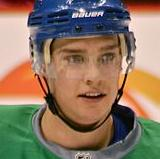

In [ ]:
img = cv2.imread(img_list[1])

print(img_list[1])
cv2_imshow(img)

In [ ]:
label_func(img_list[1])

27

## 데이터 로더 만들기

RegressionBlock: 연속된 숫자를 예측하고 싶을 때 사용한다.

In [ ]:
from fastai.vision.all import *

path = 'wiki_crop'

block = DataBlock(
    blocks = (ImageBlock, RegressionBlock),
    get_items = get_image_files,
    get_y = label_func,
    item_tfms = Resize(224),
)

loader = block.dataloaders(path)

loader.show_batch()

In [ ]:
len(loader.train.items)

49863

In [ ]:
len(loader.valid.items)

12465

## 모델 훈련

30 ~ 40분 소요

In [ ]:
from fastai.metrics import mae, mse

learn = vision_learner(loader, resnet34, loss_func=mse, metrics=mae)

learn.fine_tune(epochs = 2)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 80.9MB/s]


epoch,train_loss,valid_loss,mae,time
0,710.305115,443.759857,11.157046,04:20


epoch,train_loss,valid_loss,mae,time
0,262.684326,405.342194,9.042451,05:00
1,370.662445,376.929718,8.676592,04:59


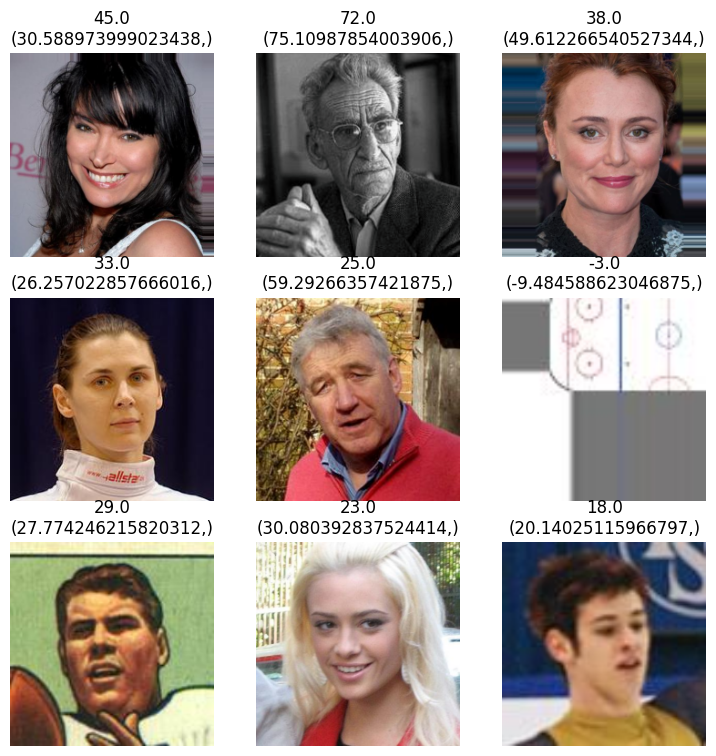

In [ ]:
learn.show_results()

# 모델 다운로드

In [ ]:
learn.export('estimate_age.pkl')

## 새로운 이미지로 테스트하기

In [ ]:
path = '/content/lee.jpg'

print(learn.predict(path))

img = cv2.imread(path)

cv2_imshow(img)

## 회귀 성능 평가 지표

회귀 모델(Regression model)에서는 정확한지를 어떻게 평가할까?

만약 나의 나이가 30살인데 우리가 훈련시킨 모델이 35살이라고 예측했다고 가정해보자.

- 정답: 30살
- 예측: 35살

모델이 얼마나 정확한지 판단하려면 간단하게 `정답-예측` 을 계산할 수 있다. 이 값이 작을 수록 정확하다고 말할 수 있다.

```
30 - 35 = -5
```

일반적으로 검증 데이터를 여러개 사용하기 때문에 여러 오차의 평균을 계산한다. 음수를 양수로 만들어주기 위해 절대값(마이너스 부호를 빼고)으로 평균을 낸다.

### MAE (Mean absolute error) - 평균 절대 오차

(정답 - 예측)의 절대값의 평균

### MSE (Mean squared error) - 평균 제곱 오차

(정답 - 예측)의 제곱값의 평균


# pre trained model download



In [ ]:
!wget http://api.dkit.kr/ai/estimate_age.pkl

--2023-11-24 05:18:20--  http://api.dkit.kr/ai/estimate_age.pkl
Resolving api.dkit.kr (api.dkit.kr)... 211.233.63.137
Connecting to api.dkit.kr (api.dkit.kr)|211.233.63.137|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 103791550 (99M)
Saving to: ‘estimate_age.pkl’

estimate_age.pkl    100%[===================>]  98.98M  3.40MB/s    in 34s     

2023-11-24 05:18:55 (2.94 MB/s) - ‘estimate_age.pkl’ saved [103791550/103791550]



In [ ]:
from fastai.vision.all import *

learn = load_learner('estimate_age.pkl') # 훈련된 모델 로드

# 송중기 사진 으로 테스트

![](https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fnewsimg.hankookilbo.com%2Fcms%2Farticlerelease%2F2017%2F07%2F24%2F201707241120478827_1.jpg&f=1&nofb=1&ipt=40fbbc929910415b9c09113fe4ea2b06e43107a963560d09942baf8797479265&ipo=images)

In [ ]:
path = '/content/song.jpg'
pred = learn.predict(path)
print(pred)

((24.54629898071289,), tensor([24.5463]), tensor([24.5463]))
